# <p><center style="font-family:newtimeroman;font-size:180%;">Lumbar Vertebrae Localization using Coordinate-based Pretraining</center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [Train CNN Model](#5)
* [Evaluate The Model](#6)
* [Train CNN Model](#7)
* [Evaluate The Model](#8)
* [Check The Model](#9)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

2025-07-29 15:55:36.540278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753804536.940053      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753804537.050096      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(dataset_path)):
        if not folder.endswith("jpgs"):
            continue
        subfolder_path = os.path.join(dataset_path, folder)
        folder = folder.split("_")[1].upper()
        for image_filename in os.listdir(subfolder_path):               
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(folder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [3]:
# Dataset
data = data('/kaggle/input/lumbar-coordinate-pretraining-dataset/data')
data.head()

100%|██████████| 8/8 [00:00<00:00, 171.41it/s]


image   label
0  /kaggle/input/lumbar-coordinate-pretraining-da...  SPIDER
1  /kaggle/input/lumbar-coordinate-pretraining-da...  SPIDER
2  /kaggle/input/lumbar-coordinate-pretraining-da...  SPIDER
3  /kaggle/input/lumbar-coordinate-pretraining-da...  SPIDER
4  /kaggle/input/lumbar-coordinate-pretraining-da...  SPIDER

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

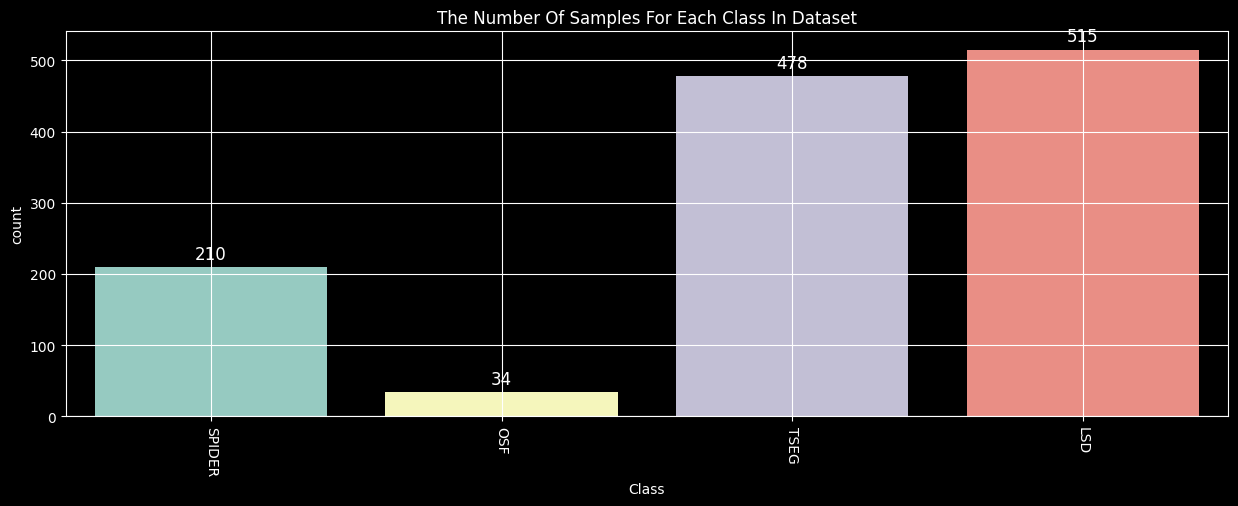

In [4]:
plt.style.use("dark_background")
plt.figure(figsize=(15,5))
ax = sns.countplot(x=data.label)
ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', padding=3, color='white', fontsize=12)
ax.set_xlabel("Class")
plt.title("The Number Of Samples For Each Class In Dataset")
plt.grid(True)
plt.xticks(rotation=-90)
plt.show()

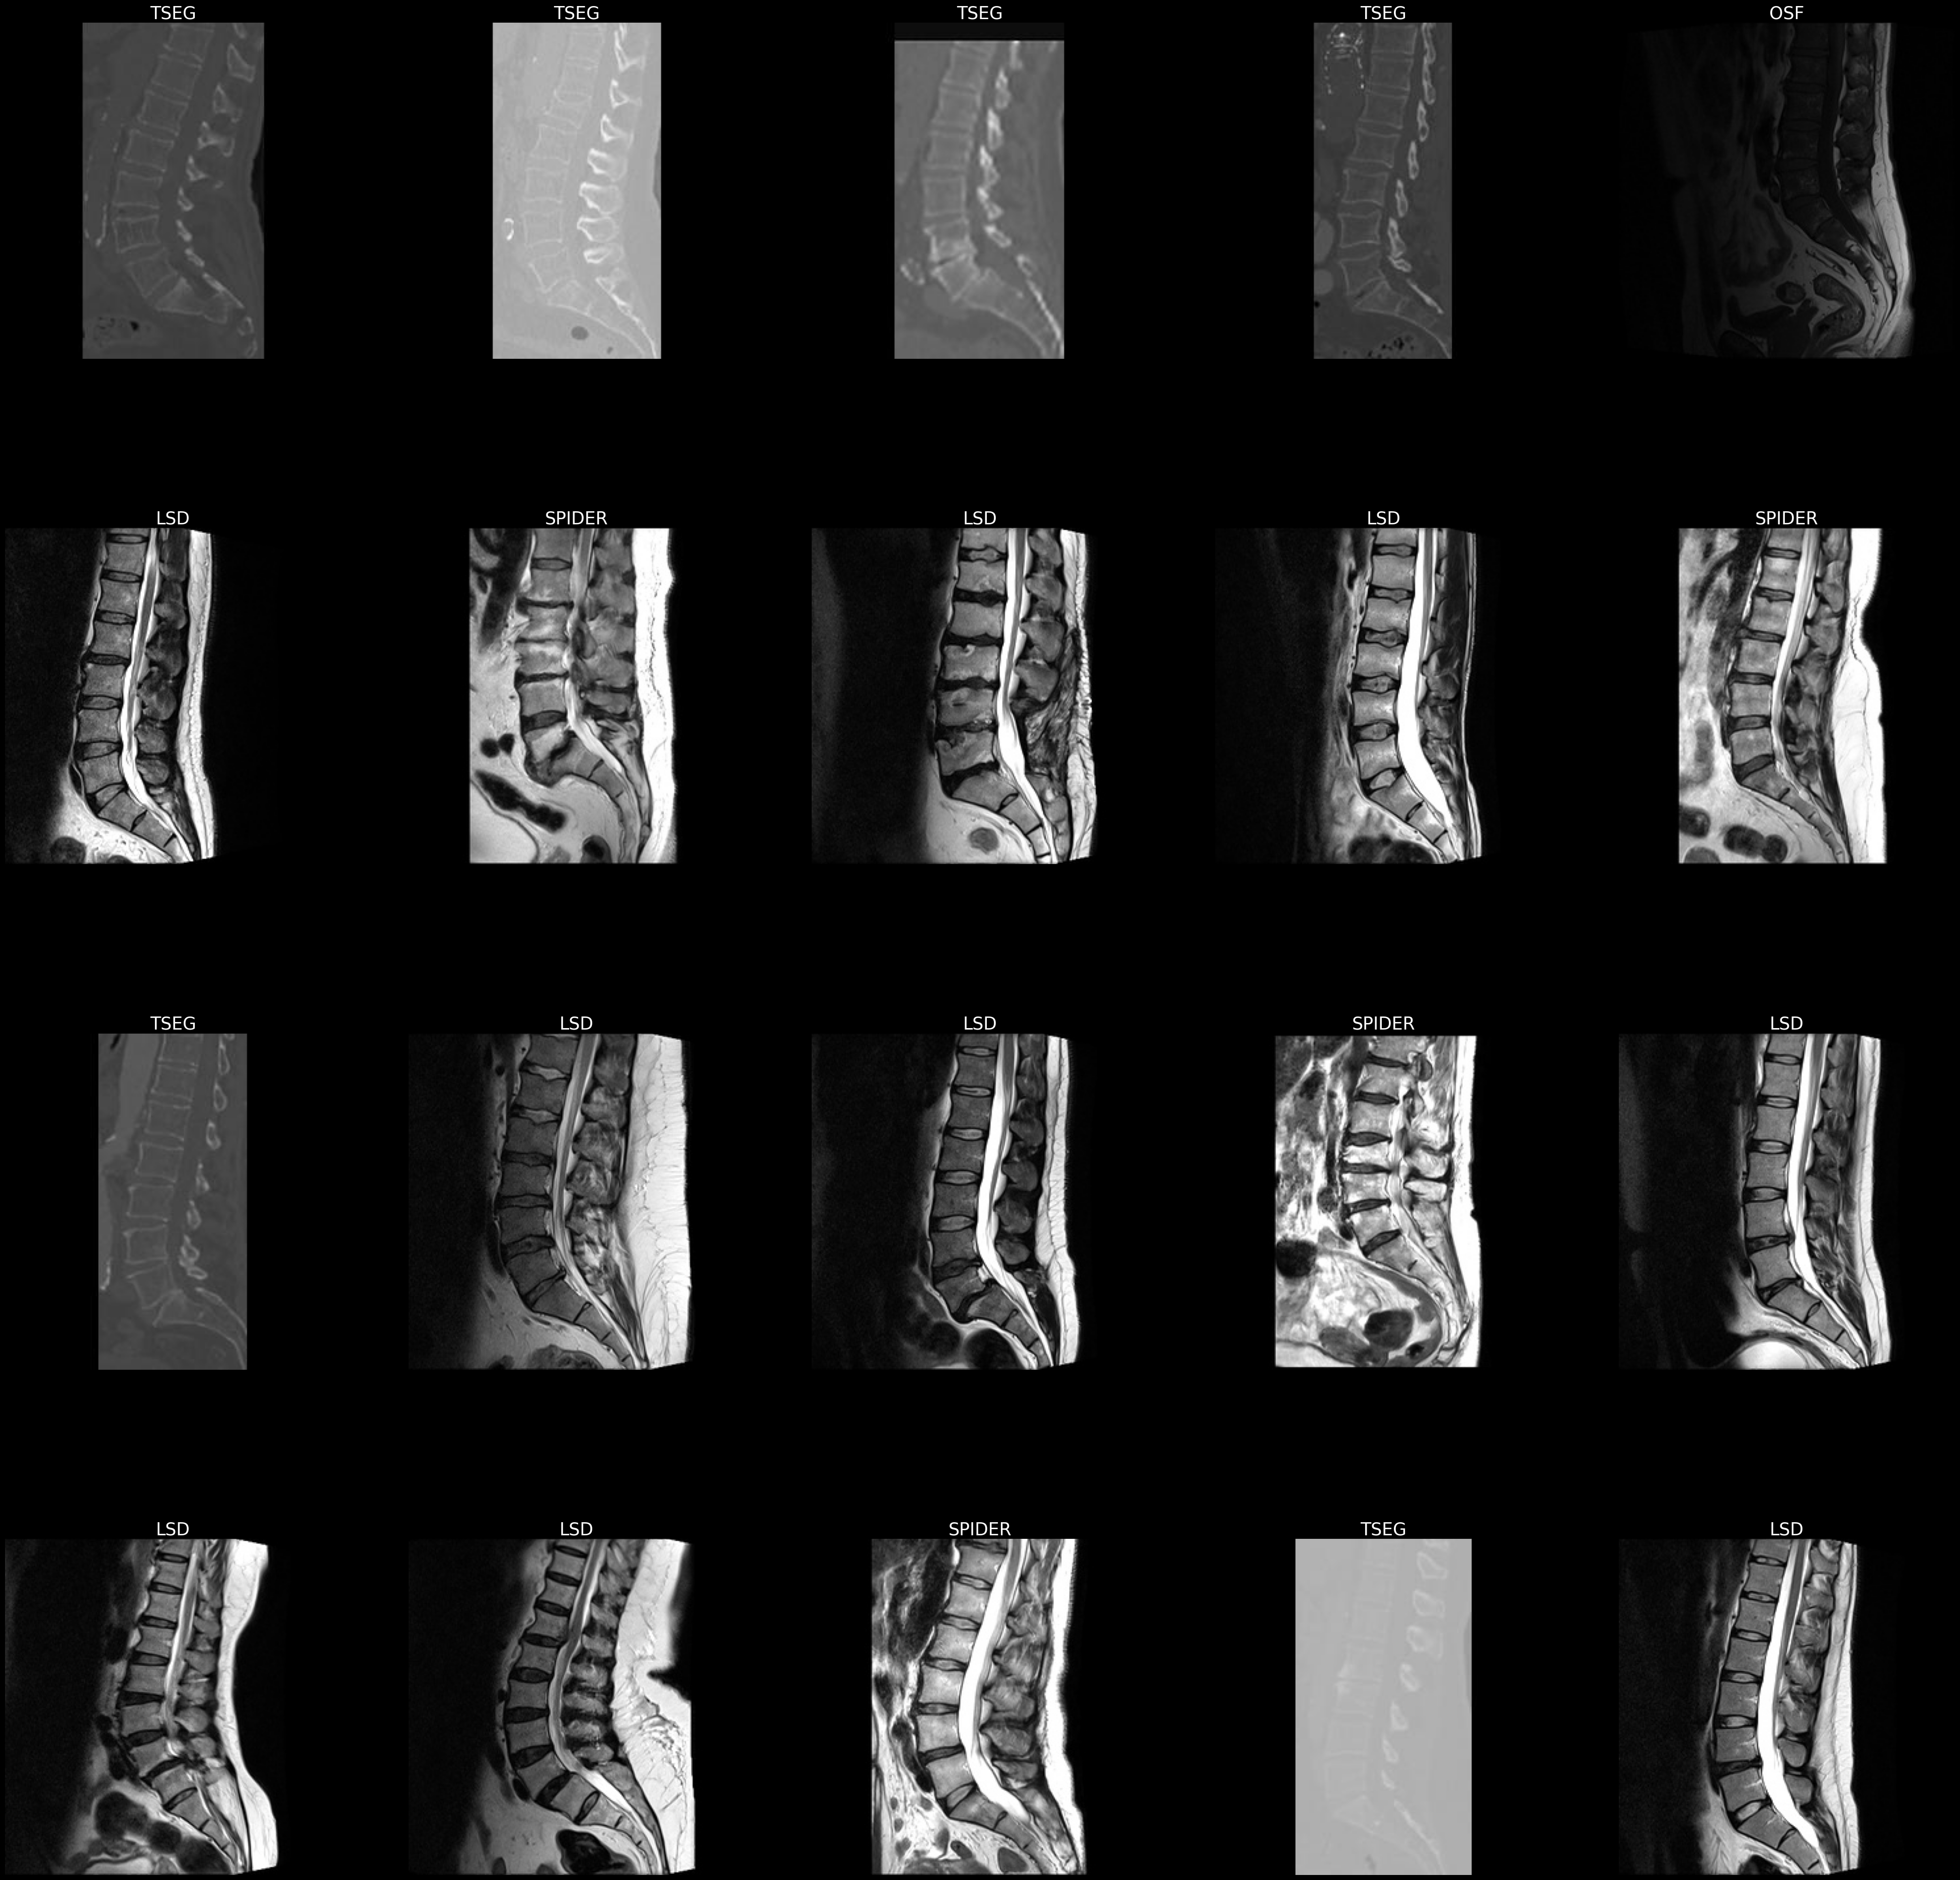

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(data),20)):
    plt.subplot(4,5,n+1)
    img=cv2.imread(data.image[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(data.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Data Augmentation </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [6]:
df_train,df_temp = train_test_split(data,test_size=.3,stratify=data.label,shuffle=True,random_state=41)
df_test,df_val = train_test_split(df_temp,test_size=.5,stratify=df_temp.label,shuffle=True,random_state=41)

In [7]:
image_size = (256, 256)
batch_size = 64 
datagen = ImageDataGenerator(
    rescale=1./255,
    
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 865 validated image filenames belonging to 4 classes.
Found 186 validated image filenames belonging to 4 classes.
Found 186 validated image filenames belonging to 4 classes.


In [8]:
class_num=list(train_generator.class_indices.keys())
class_num

['LSD', 'OSF', 'SPIDER', 'TSEG']

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [9]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(256,256,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(len(class_num),activation='softmax'))
model.summary()

I0000 00:00:1753804562.705515      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753804562.706196      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,195,524 (8.38 MB)

 Trainable params: 2,195,524 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

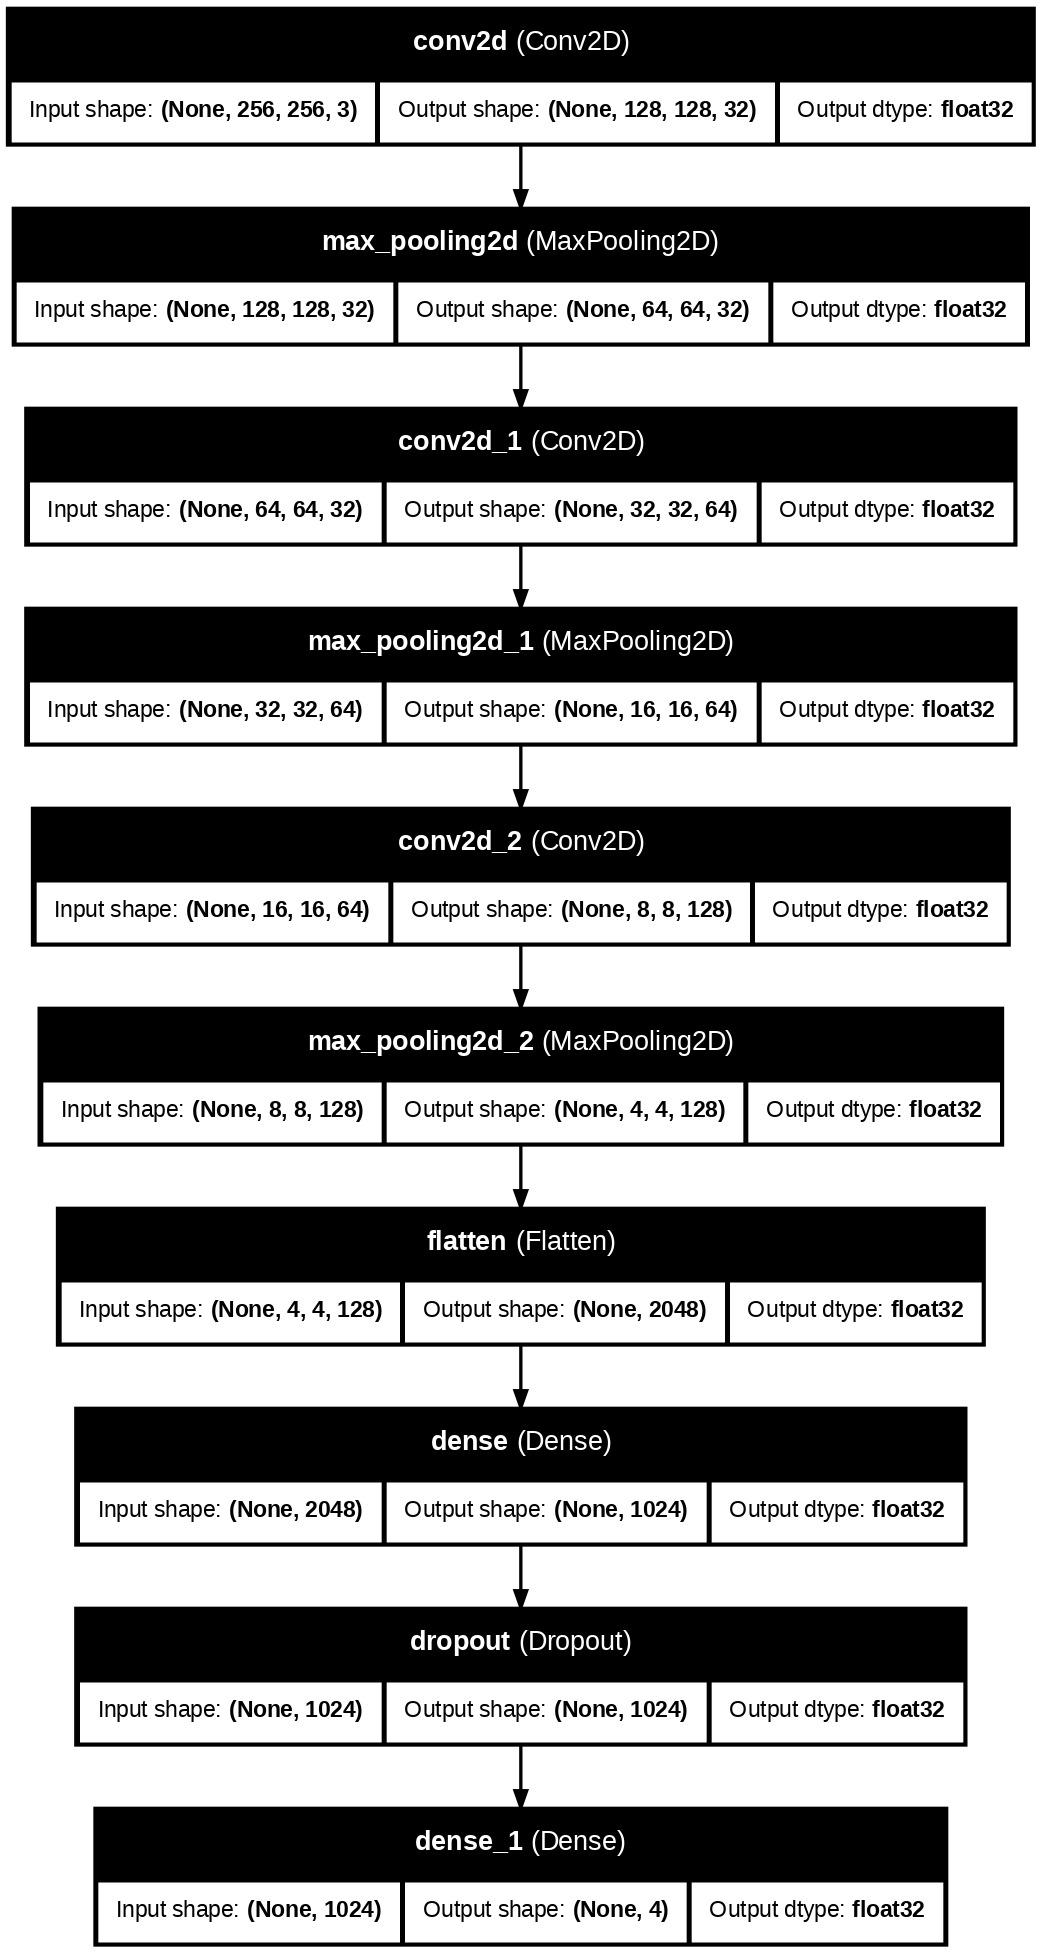

In [10]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [11]:
checkpoint_cb =ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit(train_generator,validation_data=val_generator,epochs=50,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50


I0000 00:00:1753804568.651418      64 service.cc:148] XLA service 0x7d067c20e490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753804568.653069      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753804568.653092      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753804569.291516      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/14 ━━━━━━━━━━━━━━━━━━━━ 2:03 10s/step - accuracy: 0.1250 - auc: 0.4076 - loss: 1.4016 - specificity_at_sensitivity: 0.3698

I0000 00:00:1753804575.177398      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5261 - auc: 0.8040 - loss: 0.9815 - specificity_at_sensitivity: 0.8563 - val_accuracy: 0.8925 - val_auc: 0.9784 - val_loss: 0.3511 - val_specificity_at_sensitivity: 0.9928
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.8891 - auc: 0.9757 - loss: 0.3439 - specificity_at_sensitivity: 0.9933 - val_accuracy: 0.9355 - val_auc: 0.9915 - val_loss: 0.2196 - val_specificity_at_sensitivity: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.9448 - auc: 0.9950 - loss: 0.1652 - specificity_at_sensitivity: 0.9998 - val_accuracy: 0.9409 - val_auc: 0.9956 - val_loss: 0.1688 - val_specificity_at_sensitivity: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9381 - auc: 0.9936 - loss: 0.1904 - specificity_at_sensitivity: 0.9994 - val_accuracy: 0.9301 - val_auc: 0.9924 - val_loss: 0.2029 - val_specificity_at_sensitivity: 0.9982
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accurac

<a id="6"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [12]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy       auc      loss  specificity_at_sensitivity  val_accuracy  \
0   0.698266  0.905686  0.765883                    0.976108      0.892473   
1   0.910983  0.984130  0.277179                    0.996532      0.935484   
2   0.936416  0.993572  0.182700                    0.999615      0.940860   
3   0.939884  0.994681  0.172445                    0.999615      0.930108   
4   0.950289  0.995364  0.141995                    0.999615      0.951613   
5   0.968786  0.998986  0.082317                    1.000000      0.967742   
6   0.971098  0.998781  0.080810                    1.000000      0.946237   
7   0.980347  0.999645  0.049275                    1.000000      0.983871   
8   0.986127  0.999741  0.036797                    1.000000      0.967742   
9   0.986127  0.999793  0.037037                    1.000000      0.989247   
10  0.994220  0.999917  0.024198                    1.000000      0.989247   
11  0.998844  0.999997  0.010704                    1.000000      0.989247   
12  0.997688  0.999998  0.005970                    1.000000      0.989247   

     val_auc  val_loss  val_specificity_at_sensitivity  
0   0.978355  0.351062                        0.992832  
1   0.991540  0.219558                        1.000000  
2   0.995616  0.168791                        1.000000  
3   0.992403  0.202888                        0.998208  
4   0.997654  0.120758                        1.000000  
5   0.998622  0.084861                        1.000000  
6   0.997606  0.123946                        1.000000  
7   0.998959  0.056807                        1.000000  
8   0.997948  0.101674                        1.000000  
9   0.995664  0.082140                        0.998208  
10  0.995977  0.068834                        0.998208  
11  0.996030  0.065134                        0.998208  
12  0.996107  0.064799                        0.998208

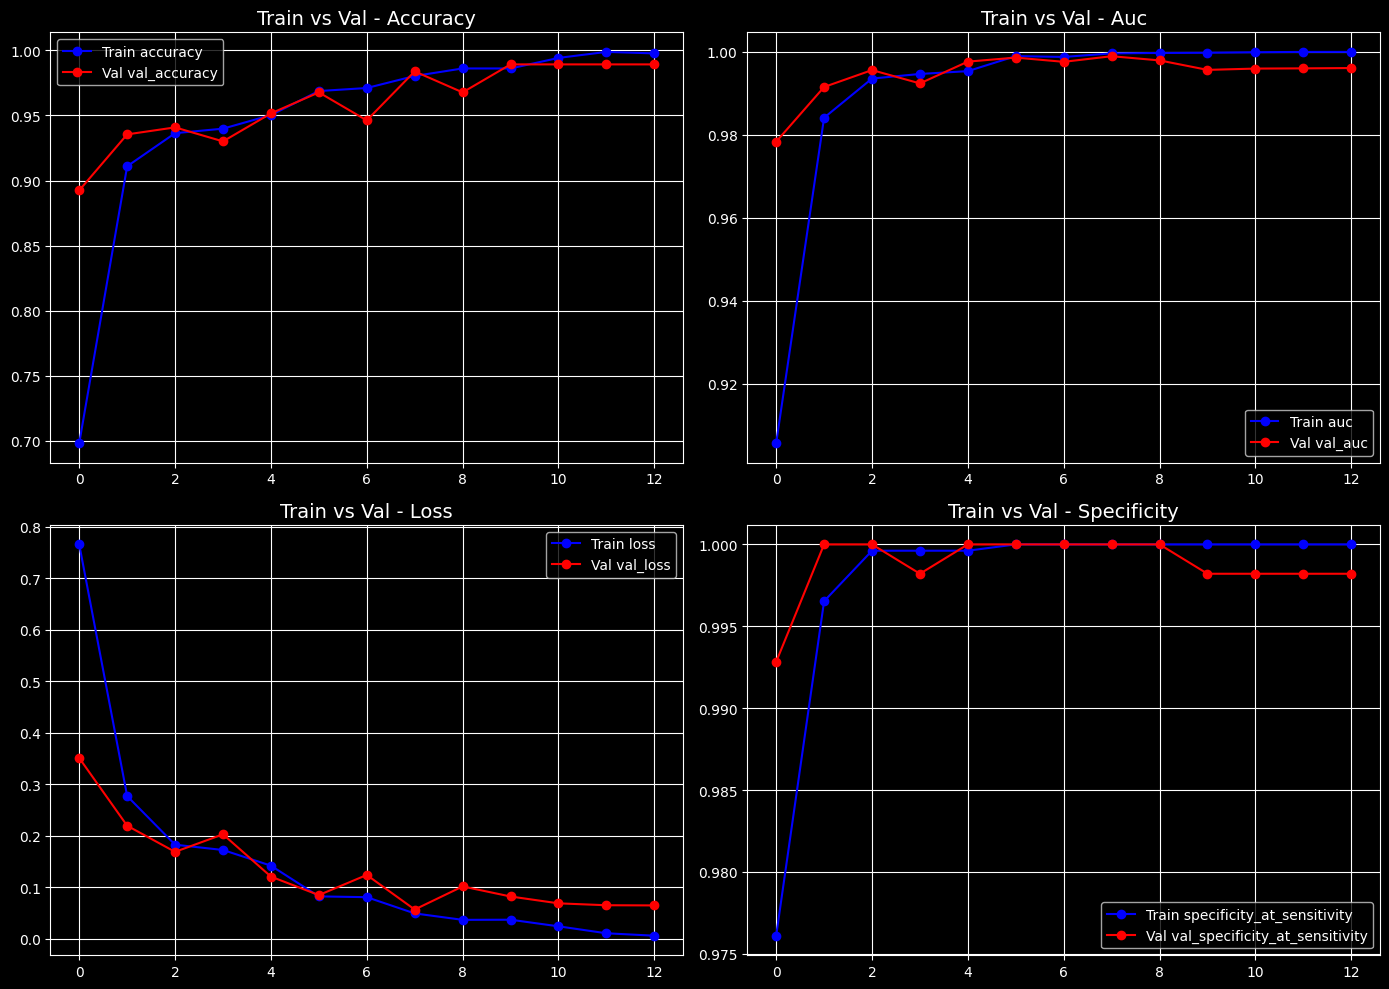

In [13]:
metrics = hist_.columns.tolist()

# Pair train/val metrics together
metric_pairs = []
for m in metrics:
    if m.startswith("val_"):
        continue  
    val_m = f"val_{m}"
    if val_m in metrics:
        metric_pairs.append((m, val_m))

# Plot dynamically
n = len(metric_pairs)
cols = 2
rows = (n + 1) // cols

plt.figure(figsize=(7 * cols, 5 * rows))

for i, (train_m, val_m) in enumerate(metric_pairs):
    plt.subplot(rows, cols, i + 1)
    plt.plot(hist_[train_m], 'b-o', label=f'Train {train_m}')
    plt.plot(hist_[val_m], 'r-o', label=f'Val {val_m}')
    plt.title(f'Train vs Val - {train_m.split("_")[0].capitalize()}', fontsize=14)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.9783 - auc: 0.9995 - loss: 0.0553 - specificity_at_sensitivity: 1.0000
Test Loss = 0.04604736343026161
Test Accuracy = 0.9838709831237793
Test Sensitivity = 1.0
Test AUC = 0.9995759725570679


<a id="7"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [15]:
base_model = tf.keras.applications.DenseNet121(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = keras.layers.Flatten()(x) 
x = keras.layers.Dropout(0.5)(x) 
outputs = keras.layers.Dense(len(class_num), activation='softmax')(x)  
model2 = keras.models.Model(inputs, outputs)
model2.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │       262,148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,299,652 (27.85 MB)

 Trainable params: 262,148 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

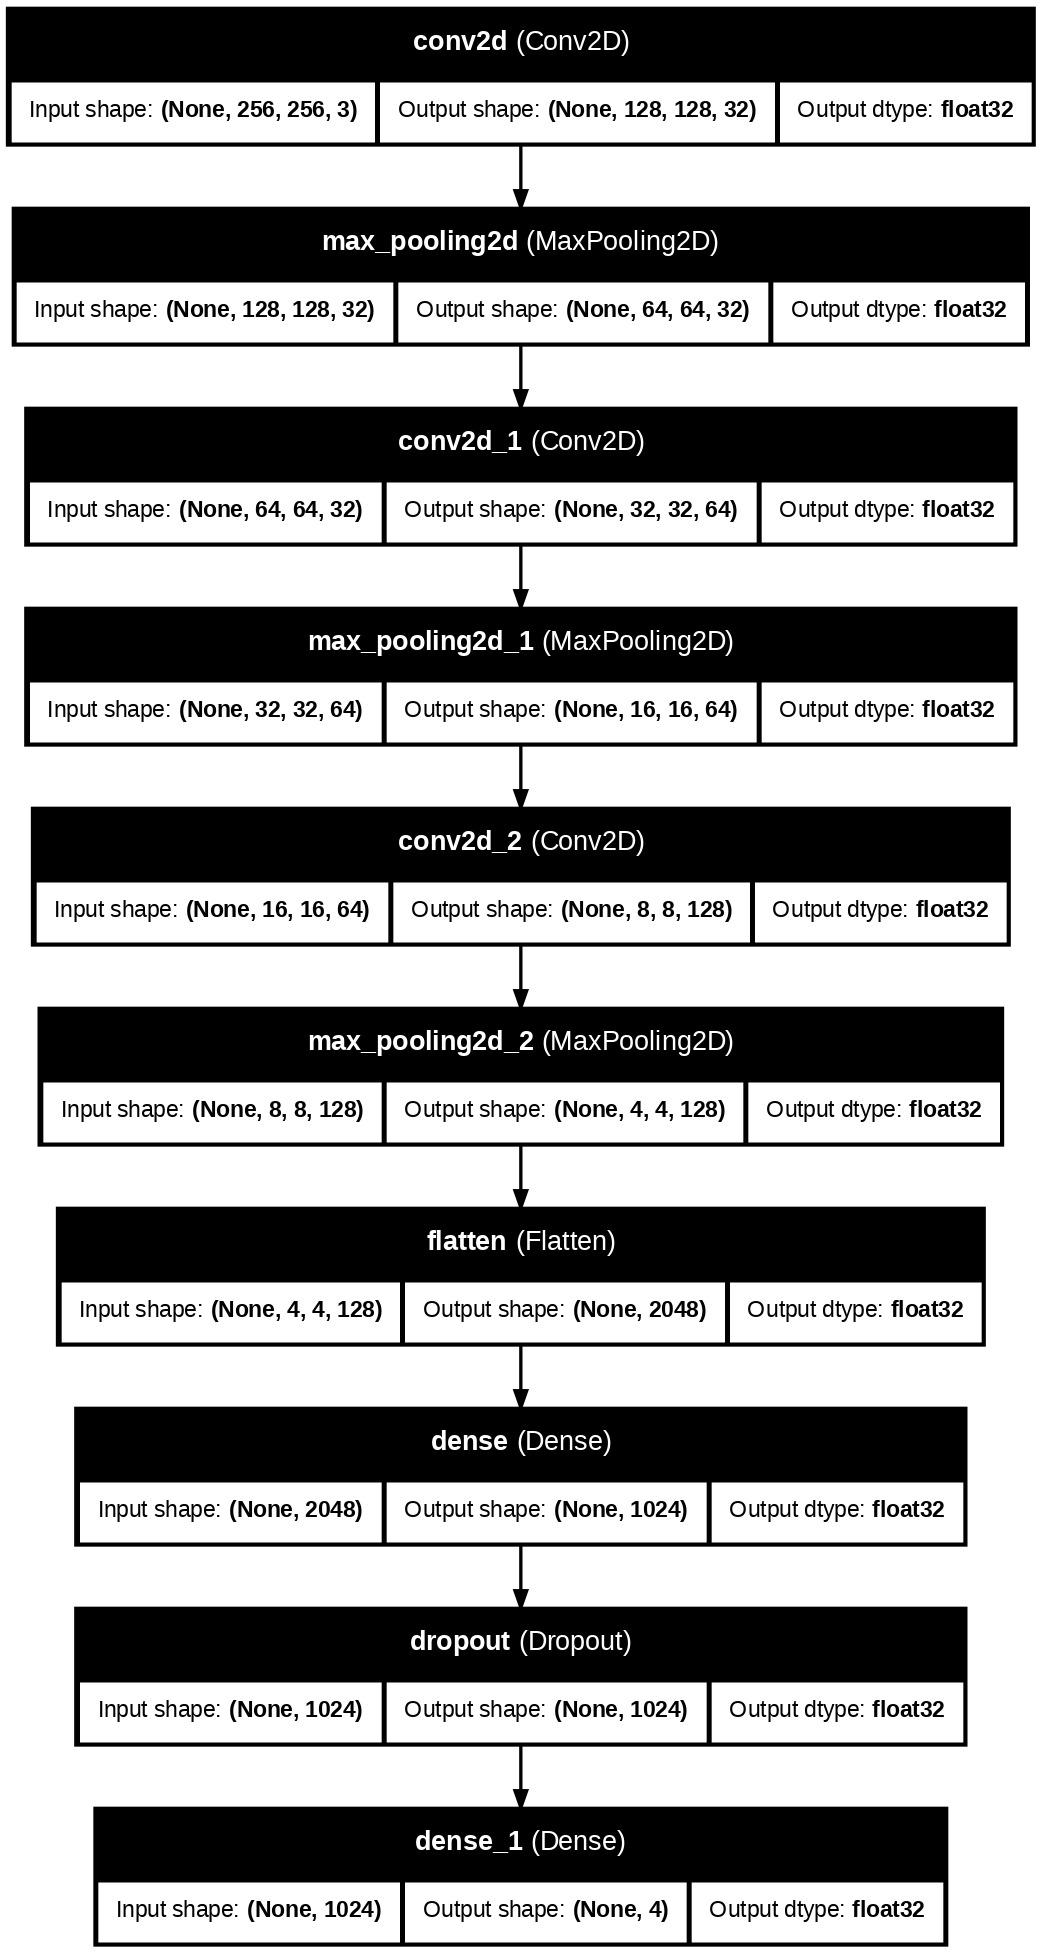

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [17]:
checkpoint_cb =ModelCheckpoint("my_keras_model2.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model2.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model2.fit(train_generator,validation_data=val_generator,epochs=50,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5691 - auc_1: 0.7404 - loss: 5.4563 - specificity_at_sensitivity_1: 0.7970 - val_accuracy: 0.9570 - val_auc_1: 0.9752 - val_loss: 1.9611 - val_specificity_at_sensitivity_1: 0.9892
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.9261 - auc_1: 0.9607 - loss: 2.4846 - specificity_at_sensitivity_1: 0.9853 - val_accuracy: 0.9677 - val_auc_1: 0.9934 - val_loss: 0.1336 - val_specificity_at_sensitivity_1: 0.9982
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.9471 - auc_1: 0.9845 - loss: 0.3130 - specificity_at_sensitivity_1: 0.9933 - val_accuracy: 0.9892 - val_auc_1: 0.9999 - val_loss: 0.0288 - val_specificity_at_sensitivity_1: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.9863 - auc_1: 0.9963 - loss: 0.0740 - specificity_at_sensitivity_1: 0.9983 - val_accuracy: 0.9946 - val_auc_1: 0.9964 - val_loss: 0.0479 - val_specificity_at_sensitivity_1: 0.9982
Epoch 5/50
14/14 ━

<a id="8"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [18]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy     auc_1      loss  specificity_at_sensitivity_1  val_accuracy  \
0   0.735260  0.860347  4.480069                      0.956840      0.956989   
1   0.929480  0.964971  1.658970                      0.985742      0.967742   
2   0.954913  0.987646  0.246865                      0.994605      0.989247   
3   0.983815  0.993876  0.107657                      0.997303      0.994624   
4   0.996532  0.999216  0.014233                      0.999615      0.994624   
5   0.997688  0.999993  0.005709                      1.000000      1.000000   
6   1.000000  1.000000  0.001371                      1.000000      1.000000   
7   1.000000  1.000000  0.000355                      1.000000      0.994624   
8   1.000000  1.000000  0.000161                      1.000000      0.994624   
9   0.998844  1.000000  0.001775                      1.000000      1.000000   
10  1.000000  1.000000  0.000558                      1.000000      1.000000   
11  1.000000  1.000000  0.000072                      1.000000      1.000000   
12  0.998844  0.999999  0.003137                      1.000000      0.989247   
13  1.000000  1.000000  0.000193                      1.000000      0.994624   
14  1.000000  1.000000  0.000214                      1.000000      0.994624   
15  1.000000  1.000000  0.000094                      1.000000      0.994624   

    val_auc_1  val_loss  val_specificity_at_sensitivity_1  
0    0.975214  1.961068                          0.989247  
1    0.993376  0.133595                          0.998208  
2    0.999904  0.028774                          1.000000  
3    0.996358  0.047860                          0.998208  
4    0.999971  0.011102                          1.000000  
5    1.000000  0.001738                          1.000000  
6    1.000000  0.002736                          1.000000  
7    0.999971  0.016604                          1.000000  
8    0.999971  0.017370                          1.000000  
9    1.000000  0.002406                          1.000000  
10   1.000000  0.001111                          1.000000  
11   1.000000  0.001722                          1.000000  
12   0.999961  0.026436                          1.000000  
13   0.999990  0.009250                          1.000000  
14   0.999981  0.011884                          1.000000  
15   0.999981  0.011921                          1.000000

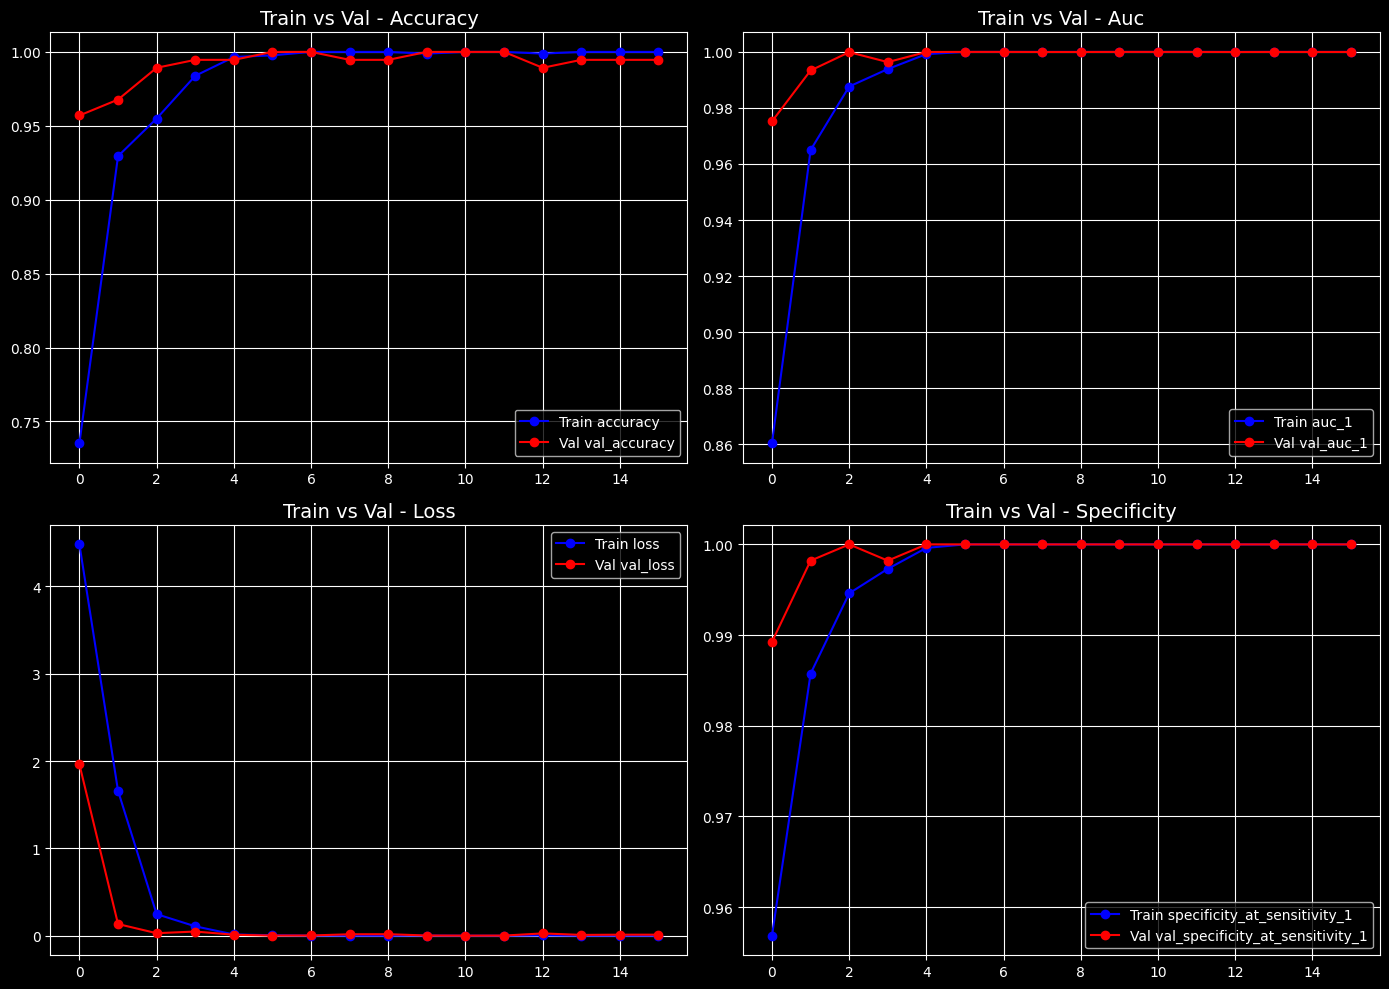

In [19]:
metrics = hist_.columns.tolist()

# Pair train/val metrics together
metric_pairs = []
for m in metrics:
    if m.startswith("val_"):
        continue  
    val_m = f"val_{m}"
    if val_m in metrics:
        metric_pairs.append((m, val_m))

# Plot dynamically
n = len(metric_pairs)
cols = 2
rows = (n + 1) // cols

plt.figure(figsize=(7 * cols, 5 * rows))

for i, (train_m, val_m) in enumerate(metric_pairs):
    plt.subplot(rows, cols, i + 1)
    plt.plot(hist_[train_m], 'b-o', label=f'Train {train_m}')
    plt.plot(hist_[val_m], 'r-o', label=f'Val {val_m}')
    plt.title(f'Train vs Val - {train_m.split("_")[0].capitalize()}', fontsize=14)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
score, acc,sensitivity,auc = model2.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.9915 - auc_1: 1.0000 - loss: 0.0070 - specificity_at_sensitivity_1: 1.0000
Test Loss = 0.004502787720412016
Test Accuracy = 0.9946236610412598
Test Sensitivity = 1.0
Test AUC = 0.9999904036521912


<a id="9"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Check The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [21]:
y_test = test_generator.classes
predictions = model2.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Actual  Prediction
0         0           0
1         3           3
2         0           0
3         2           2
4         0           0
..      ...         ...
181       3           3
182       0           0
183       0           0
184       0           0
185       2           2

[186 rows x 2 columns]

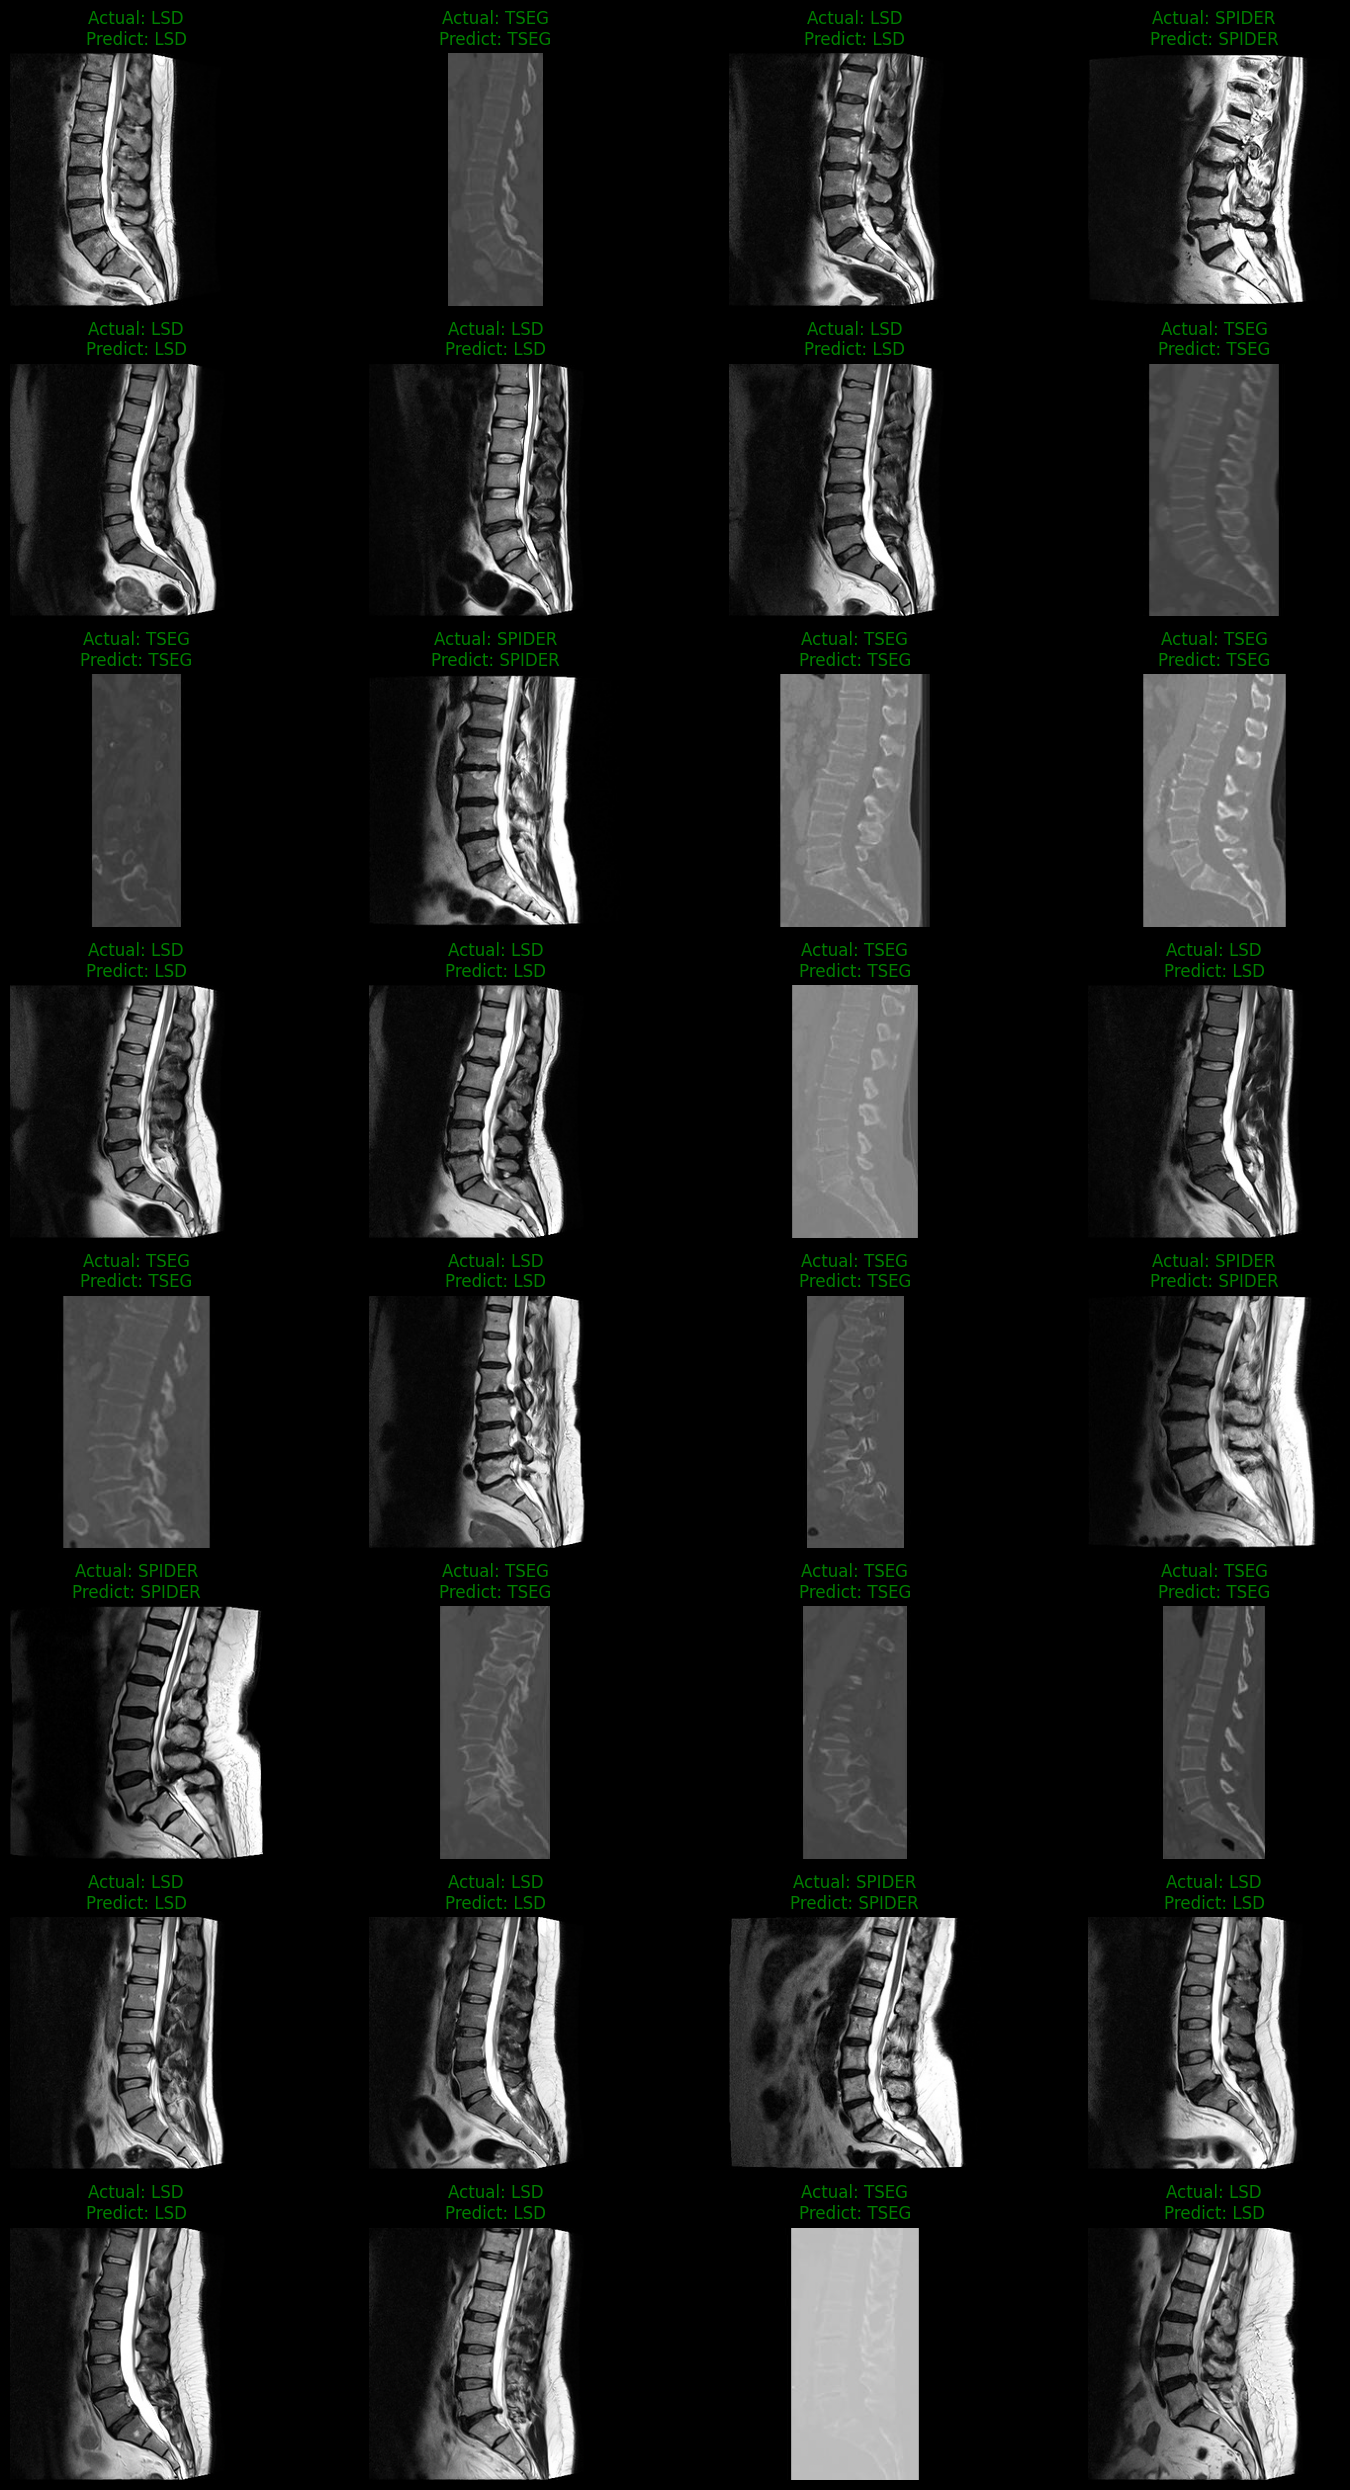

In [22]:
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(15, 25))
for n in range(32):
    plt.subplot(8, 4, n + 1)
    plt.imshow(images[n])
    plt.axis('off')
    true_name = class_num[y_test[n]]
    pred_name = class_num[y_pred[n]]
    plt.title(f"Actual: {true_name}\nPredict: {pred_name}", fontsize=12, color='green' if true_name == pred_name else 'red')
plt.tight_layout()
plt.show()

array([[77,  0,  1,  0],
       [ 0,  5,  0,  0],
       [ 0,  0, 31,  0],
       [ 0,  0,  0, 72]])

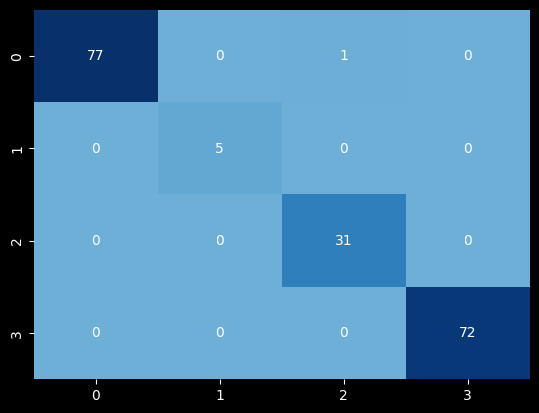

In [23]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [24]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       1.00      1.00      1.00         5
           2       0.97      1.00      0.98        31
           3       1.00      1.00      1.00        72

    accuracy                           0.99       186
   macro avg       0.99      1.00      0.99       186
weighted avg       0.99      0.99      0.99       186

